In [77]:
from scipy.stats import uniform
import datetime

import pandas as pd
import numpy as np

import json
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sktime.datatypes import convert_to

from sktime.dists_kernels import AggrDist, ScipyDist
from sktime.datasets import load_unit_test

from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.feature_selection import RFE

# Model import
from xgboost import XGBClassifier, DMatrix

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

<span style="font-size:1.5em;">Settings and pre-execution analysis functions</span>

In [78]:
DESIGN_NAME = "FabScalar"
DESIGN = DESIGN_NAME.lower()
REPO_PATH = "/mnt/shared-scratch/Hu_J/minh.luu/github/vcdiag_fabscalar"

DATA_ANALYSIS_PATH = f"{REPO_PATH}/data_analysis"
CONFIG_PATH = f"{REPO_PATH}/configs/{DESIGN}.json"
FINAL_BUG_DATA_PATH_TRAIN = f"{DATA_ANALYSIS_PATH}/data/final_data/train/"
FINAL_BUG_DATA_PATH_TEST = f"{DATA_ANALYSIS_PATH}/data/final_data/test/"

In [79]:
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)
sim_and_extract_config = config["sim_and_extract"]
extract_config = sim_and_extract_config["extract"]
BEFORE_FAILURE_TIMEFRAME = extract_config["line_limit"]
label_mapping = config["general"]["label_mapping"]

In [80]:
# Count the frequency of each label in the train label.csv
def count_label_frequency(label_file_path):
    label_freq = {}
    with open(label_file_path, 'r') as f:
        for line in f:
            label = line.split(',')[1].strip()
            if label not in label_freq:
                label_freq[label] = 1
            else:
                label_freq[label] += 1
    return label_freq


display(count_label_frequency(FINAL_BUG_DATA_PATH_TRAIN + "label.csv"))
display(count_label_frequency(FINAL_BUG_DATA_PATH_TEST + "label.csv"))

{'FECHONE': 744,
 'FECHWO': 774,
 'DECODE': 651,
 'DISP': 382,
 'EXEC': 630,
 'INSBUF': 450,
 'ISSUE': 460,
 'LSU': 558,
 'MAPABLE': 528,
 'REGREAD': 641,
 'REIRE': 411,
 'RENAME': 387}

{'FECHONE': 94,
 'FECHWO': 126,
 'DECODE': 120,
 'DISP': 50,
 'EXEC': 93,
 'INSBUF': 70,
 'ISSUE': 87,
 'LSU': 75,
 'MAPABLE': 91,
 'REGREAD': 113,
 'REIRE': 48,
 'RENAME': 63}

<span style="font-size:1.5em;">Support classes and functions</span>

In [81]:
class StopExecution(Exception):
    def _render_traceback_(self):
        return []

<span style="font-size:1.5em;">Training</span>

<span style="font-size:1em;">Data import and preprocess</span>

In [82]:
# Read training data from csv
X_train = pd.read_csv(f"{FINAL_BUG_DATA_PATH_TRAIN}/data.csv")
label_train_df = pd.read_csv(
    f"{FINAL_BUG_DATA_PATH_TRAIN}/label.csv", index_col=0, header=None)
y_train = label_train_df.to_numpy().flatten()

# Read testing data from csv
X_test = pd.read_csv(f"{FINAL_BUG_DATA_PATH_TEST}/data.csv")

label_test_df = pd.read_csv(
    f"{FINAL_BUG_DATA_PATH_TEST}/label.csv", index_col=0, header=None)
y_test = label_test_df.to_numpy().flatten()

# Drop column "instances" for both training and testing data
X_train = X_train.drop(columns=["instances"])
X_test = X_test.drop(columns=["instances"])

X_train_original = X_train.copy()
X_test_original = X_test.copy()
y_train_original = label_train_df.to_numpy().flatten()
y_test_original = label_test_df.to_numpy().flatten()

In [83]:
X_train = X_train_original.copy()
X_test = X_test_original.copy()
y_train = y_train_original.copy()
y_test = y_test_original.copy()

print(f"Label mapping: {label_mapping}")

# Convert the labels to the corresponding values in the label_mapping
for i in range(len(y_train)):
    y_train[i] = label_mapping[y_train[i]]
for i in range(len(y_test)):
    y_test[i] = label_mapping[y_test[i]]

# cap the training dataset at 200 samples per class
X_train = X_train.copy()
y_train = y_train.copy()
X_train["label"] = y_train
X_train = X_train.groupby("label").head(3000)
y_train = X_train["label"]
X_train = X_train.drop(columns=["label"])

label_freq_train = {}
for label in y_train:
    if label not in label_freq_train:
        label_freq_train[label] = 1
    else:
        label_freq_train[label] += 1
        
label_freq_test = {}
for label in y_test:
    if label not in label_freq_test:
        label_freq_test[label] = 1
    else:
        label_freq_test[label] += 1
       
display(label_freq_train)
display(label_freq_test)

Label mapping: {'FECHONE': 'FetchStage1', 'FECHWO': 'FetchStage2', 'DECODE': 'Decode', 'INSBUF': 'InstructionBuffer', 'RENAME': 'Rename', 'DISP': 'Dispatch', 'ISSUE': 'IssueQueue', 'REGREAD': 'RegRead', 'EXEC': 'Execution', 'LSU': 'LoadStoreUnit', 'REIRE': 'Retire', 'MAPABLE': 'ArchMapTable'}


{'FetchStage1': 744,
 'FetchStage2': 774,
 'Decode': 651,
 'Dispatch': 382,
 'Execution': 630,
 'InstructionBuffer': 450,
 'IssueQueue': 460,
 'LoadStoreUnit': 558,
 'ArchMapTable': 528,
 'RegRead': 641,
 'Retire': 411,
 'Rename': 387}

{'FetchStage1': 94,
 'FetchStage2': 126,
 'Decode': 120,
 'Dispatch': 50,
 'Execution': 93,
 'InstructionBuffer': 70,
 'IssueQueue': 87,
 'LoadStoreUnit': 75,
 'ArchMapTable': 91,
 'RegRead': 113,
 'Retire': 48,
 'Rename': 63}

In [84]:
# convert all labels to float
le = LabelEncoder()
y_train_float = le.fit_transform(y_train)
y_test_float = le.transform(y_test)

# prep stats
classes = np.unique(y_train_float)
n_classes = len(classes)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_float
)

display(f"Weights: {class_weights}")
class_weights = {i: class_weights[i] for i in range(n_classes)}
max_delta_step = 1

'Weights: [1.04419192 0.8469022  1.44328098 0.87513228 0.74103943 0.71231697\n 1.22518519 1.19855072 0.98805257 0.8601144  1.42463394 1.34144363]'

In [85]:
columns_to_drop = [name for name in X_train.columns if any([name.endswith(suffix) for suffix in ["_kurt"]])]

X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

In [86]:
display(X_train.head())
display(X_train.shape)
display(y_train)

,1__0.1,1__0.5,1__0.9,1__0.25,1__0.75,1__max,1__mean,1__min,1__std,2__0.1,...,4860__std,4861__0.1,4861__0.5,4861__0.9,4861__0.25,4861__0.75,4861__max,4861__mean,4861__min,4861__std
0,120.0,1000.0,1880.0,450.0,1550.0,2100.0,1005.111111,0.0,648.535491,1.0,...,24.784791,34.0,34.0,34.0,34.0,34.0,120.0,37.822222,34.0,17.923181
1,440.0,2600.0,4760.0,1250.0,3950.0,5300.0,2602.110092,0.0,1576.949160,1.0,...,16.409773,34.0,34.0,34.0,34.0,34.0,120.0,35.577982,34.0,11.595253
2,94.0,850.0,1610.0,375.0,1325.0,1800.0,855.897436,0.0,560.782902,1.0,...,26.591248,34.0,34.0,34.0,34.0,34.0,120.0,38.410256,34.0,19.217204
3,130.0,1050.0,1970.0,475.0,1625.0,2200.0,1054.893617,0.0,677.725969,1.0,...,24.279535,34.0,34.0,34.0,34.0,34.0,120.0,37.659574,34.0,17.546555
4,76.0,700.0,1340.0,300.0,1100.0,1500.0,706.969697,0.0,472.655298,1.0,...,28.834395,34.0,34.0,34.0,34.0,34.0,120.0,39.212121,34.0,20.838302


(6616, 43749)

0             FetchStage1
1             FetchStage1
2             FetchStage1
3             FetchStage1
4             FetchStage1
5             FetchStage1
6             FetchStage1
7             FetchStage1
8             FetchStage1
9             FetchStage1
10            FetchStage1
11            FetchStage1
12            FetchStage1
13            FetchStage1
14            FetchStage1
15            FetchStage1
16            FetchStage1
17            FetchStage1
18            FetchStage1
19            FetchStage1
20            FetchStage1
21            FetchStage1
22            FetchStage1
23            FetchStage1
24            FetchStage1
25            FetchStage1
26            FetchStage1
27            FetchStage1
28            FetchStage1
29            FetchStage1
30            FetchStage1
31            FetchStage1
32            FetchStage1
33            FetchStage1
34            FetchStage1
35            FetchStage1
36            FetchStage1
37            FetchStage1
38          

<span style="font-size:1em;">ML model definition and training</span>

In [87]:
import torch
cuda_available = torch.cuda.is_available()
device = 'cpu' if not cuda_available else 'cuda'
display(device)

'cuda'

In [88]:
# XGBoost parameters
xgboost_params = {
    'objective': 'multi:multi:softprob',
    'num_class': len(np.unique(y_train_float)),
    'eval_metric': ["merror", "mlogloss"],
    # 'n_estimators': 500,
    'n_jobs': -1,
    'early_stopping_rounds': 10,
    'weight': class_weights,
    # 'max_delta_step': max_delta_step,
    'tree_method': 'gpu_hist' if cuda_available else 'auto',
    'predictor': 'gpu_predictor' if cuda_available else 'cpu_predictor'
}

In [89]:
# Define the XGBoost classifier
model = XGBClassifier(**xgboost_params)
eval_set = [(X_train, y_train_float), (X_test, y_test_float)]

In [90]:
model.fit(X_train, y_train_float, eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.25030	validation_0-mlogloss:1.56918	validation_1-merror:0.47767	validation_1-mlogloss:1.93004
[1]	validation_0-merror:0.12470	validation_0-mlogloss:1.19974	validation_1-merror:0.37184	validation_1-mlogloss:1.66644
[2]	validation_0-merror:0.10369	validation_0-mlogloss:0.96766	validation_1-merror:0.36117	validation_1-mlogloss:1.50067
[3]	validation_0-merror:0.08752	validation_0-mlogloss:0.80211	validation_1-merror:0.33689	validation_1-mlogloss:1.37742
[4]	validation_0-merror:0.07557	validation_0-mlogloss:0.67555	validation_1-merror:0.32524	validation_1-mlogloss:1.30043
[5]	validation_0-merror:0.06454	validation_0-mlogloss:0.57569	validation_1-merror:0.31165	validation_1-mlogloss:1.22927
[6]	validation_0-merror:0.05638	validation_0-mlogloss:0.49692	validation_1-merror:0.31068	validation_1-mlogloss:1.17352
[7]	validation_0-merror:0.04943	validation_0-mlogloss:0.43282	validation_1-merror:0.30097	validation_1-mlogloss:1.12915
[8]	validation_0-merror:0.04625	validati

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_class=12, num_parallel_tree=None, ...)

<span style="font-size:1.5em;">Testing</span>

In [91]:
results = model.evals_result()
# display(results)

# Graph the training and testing error
train_error = results["validation_0"]["merror"]
test_error = results["validation_1"]["merror"]
train_logloss = results["validation_0"]["mlogloss"]
test_logloss = results["validation_1"]["mlogloss"]

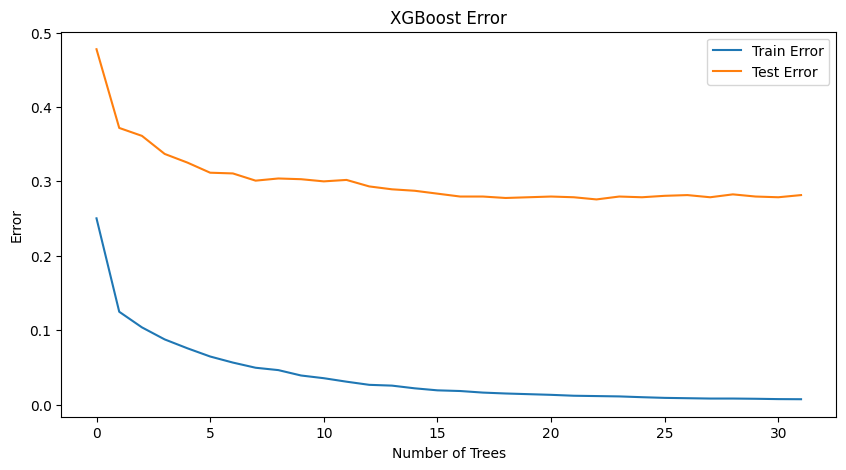

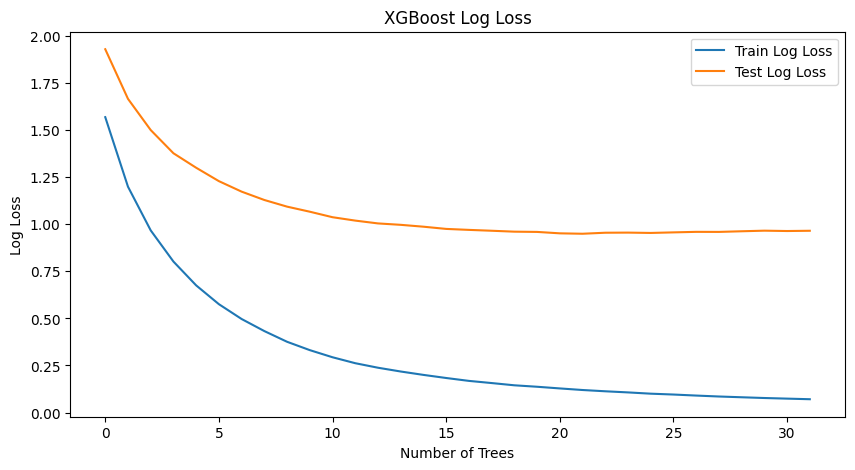

In [92]:
# Plot classification error
plt.figure(figsize=(10, 5))
plt.plot(train_error, label="Train Error")
plt.plot(test_error, label="Test Error")
plt.xlabel("Number of Trees")
plt.ylabel("Error")
plt.title("XGBoost Error")
plt.legend()
plt.show()

# Plot log loss
plt.figure(figsize=(10, 5))
plt.plot(train_logloss, label="Train Log Loss")
plt.plot(test_logloss, label="Test Log Loss")
plt.xlabel("Number of Trees")
plt.ylabel("Log Loss")
plt.title("XGBoost Log Loss")
plt.legend()
plt.show()

In [93]:
y_pred_float = model.predict(X_test)

# if this is binary classification, np.argmax is needed
if n_classes == 2:
    y_pred_float = np.argmax(y_pred_float, axis=1)

y_pred = le.inverse_transform(y_pred_float)
y_pred_proba = model.predict_proba(X_test)

0.7213592233009709
0.8592233009708737


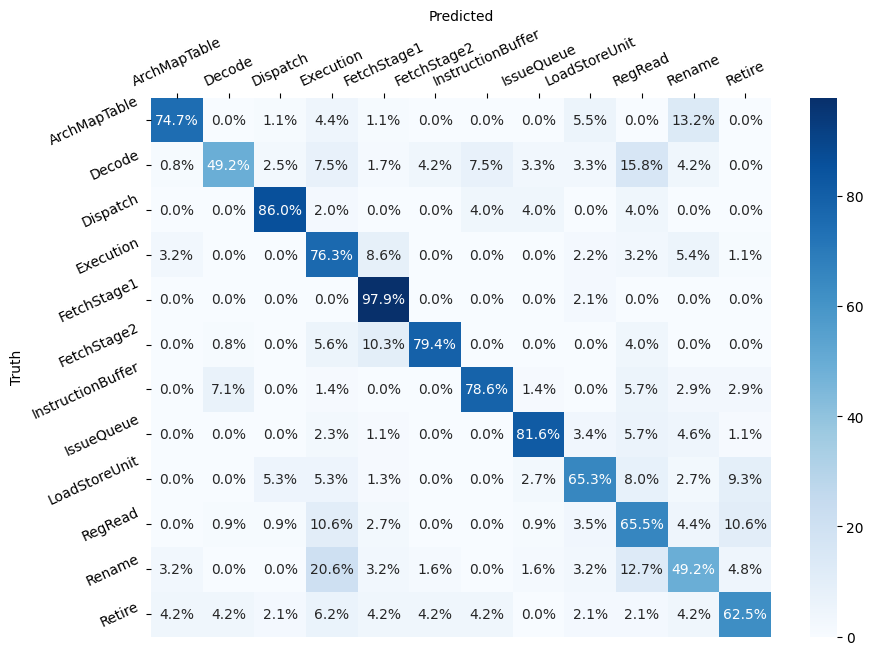

In [94]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, top_k_accuracy_score

acs = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cr = classification_report(y_test, y_pred, digits=4, output_dict=True)
top3_acs = top_k_accuracy_score(y_test, y_pred_proba, k=3 if n_classes > 3 else n_classes)

print(acs)
print(top3_acs)

# Convert integer labels for the confusion matrix to string labels
labels = np.unique(y_train)

# Plot confusion matrix with seaborn
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm, annot=True, fmt=".1f", cmap='Blues',
                 xticklabels=labels, yticklabels=labels)
# Add % sign to heatmap
for t in ax.texts:
    t.set_text(t.get_text() + "%")
plt.xticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)
plt.yticks(ticks=np.arange(len(labels)) + 0.5, labels=labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.tick_params(axis='x', rotation=25)

ax.yaxis.tick_left()
ax.yaxis.set_label_position('left')
ax.tick_params(axis='y', rotation=25)


# Save the confusion matrix and classification report to a file
# Create a folder to store the logs if it does not exist
if not os.path.exists(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs"):
    os.makedirs(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs")
plt.savefig(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs/cm_xgb_{BEFORE_FAILURE_TIMEFRAME}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png", bbox_inches='tight', dpi=150)
# round to 4 decimal places for better readability
cr_df = pd.DataFrame(cr).transpose().round(4)
cr_df.to_csv(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs/cr_xgb_{BEFORE_FAILURE_TIMEFRAME}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv")

In [95]:
# Create a DataFrame to display the probabilities in a more descriptive way
df_prob = pd.DataFrame(y_pred_proba, columns=[
                       f'{class_name}_prob' for class_name in le.classes_])
df_prob['True_Label'] = y_test
df_prob['Predicted_Label'] = y_pred

# Inverse transform the labels
# df_prob['True_Label'] = le.inverse_transform(df_prob['True_Label'])
# df_prob['Predicted_Label'] = le.inverse_transform(df_prob['Predicted_Label'])

# Show only misclassified instances
df_prob = df_prob[df_prob['True_Label'] != df_prob['Predicted_Label']]

# Print the entire DataFrame
pd.set_option('display.max_rows', None)
display(df_prob)

,ArchMapTable_prob,Decode_prob,Dispatch_prob,Execution_prob,FetchStage1_prob,FetchStage2_prob,InstructionBuffer_prob,IssueQueue_prob,LoadStoreUnit_prob,RegRead_prob,Rename_prob,Retire_prob,True_Label,Predicted_Label
92,0.057346,0.013457,0.037868,0.144139,0.045521,0.025842,0.009142,0.030730,0.313016,0.083194,0.213726,0.026019,FetchStage1,LoadStoreUnit
93,0.032515,0.030146,0.012451,0.193931,0.280136,0.013818,0.007319,0.009223,0.288318,0.069728,0.050682,0.011733,FetchStage1,LoadStoreUnit
100,0.006622,0.028106,0.026545,0.056354,0.422824,0.220939,0.010573,0.027435,0.017520,0.119320,0.048630,0.015131,FetchStage2,FetchStage1
101,0.002692,0.035898,0.009255,0.045634,0.763087,0.087584,0.004441,0.007368,0.005052,0.008213,0.007130,0.023645,FetchStage2,FetchStage1
102,0.001516,0.006587,0.006063,0.004903,0.923293,0.035063,0.002501,0.002869,0.002511,0.004331,0.003116,0.007248,FetchStage2,FetchStage1
104,0.014311,0.092143,0.082004,0.063413,0.049958,0.160503,0.042409,0.019668,0.022651,0.277471,0.039409,0.136062,FetchStage2,RegRead
105,0.002850,0.038013,0.007960,0.075058,0.722960,0.092743,0.004703,0.007802,0.005350,0.008697,0.008825,0.025038,FetchStage2,FetchStage1
106,0.008092,0.015481,0.033294,0.532652,0.016498,0.025444,0.010940,0.022173,0.011501,0.247521,0.043668,0.032734,FetchStage2,Execution
112,0.007851,0.015021,0.032305,0.516817,0.011684,0.024688,0.044667,0.021514,0.011159,0.240162,0.042370,0.031761,FetchStage2,Execution
113,0.002781,0.012686,0.010212,0.047149,0.788426,0.079683,0.004589,0.007613,0.005220,0.008486,0.007366,0.025788,FetchStage2,FetchStage1


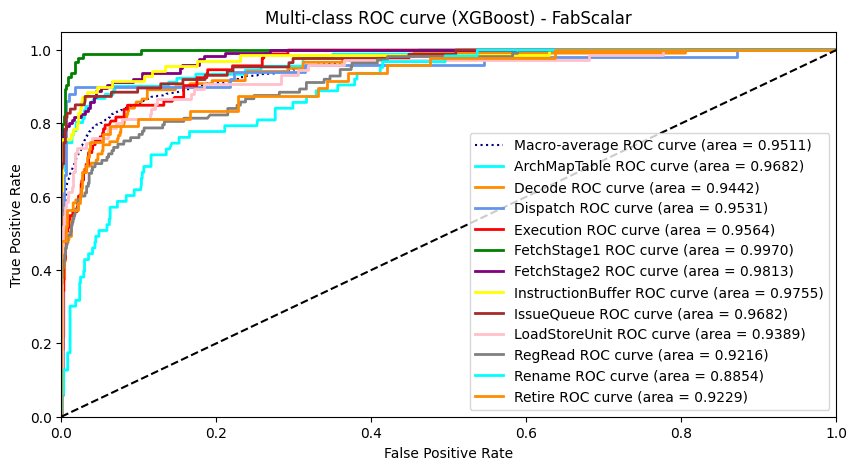

In [96]:
# Graph multi-class ROC curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

n_classes = len(count_label_frequency(FINAL_BUG_DATA_PATH_TRAIN + "label.csv"))
class_names = le.classes_
y_test_bin = label_binarize(y_test, classes=class_names)
y_pred_bin = y_pred_proba

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 5))
plt.plot(fpr["macro"], tpr["macro"], label="Macro-average ROC curve (area = {:.4f})".format(roc_auc["macro"]), color="navy", linestyle=":")
colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "purple", "yellow", "brown", "pink", "gray"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label="{0} ROC curve (area = {1:.4f})".format(class_names[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Multi-class ROC curve (XGBoost) - {DESIGN_NAME}")
plt.legend(loc="lower right")

# Save the ROC curve
plt.savefig(f"{DATA_ANALYSIS_PATH}/logs/ml_metrics_logs/roc_xgb_{BEFORE_FAILURE_TIMEFRAME}_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png", bbox_inches='tight', dpi=150)

plt.show()